# Hands on session: Variational Autoencoders (VAE)
In this exercise, we reuse the data from the second Autoencoder example and train a Variational Autoencoder (VAE) to reduce the dimensionality of the calcium imaging data. Recap: The dataset contains the spike times points of >100 neurons along with the behavioral data of a mouse.

This exercise refers to [Chapter 9 "Variational Autoencoders (VAE)"](https://www.fabriziomusacchio.com/teaching/teaching_dimensionality_reduction_in_neuroscience/09_vae) of the "[Dimensionality reduction in neuroscience](https://www.fabriziomusacchio.com/teaching/teaching_dimensionality_reduction_in_neuroscience/)" course (tutor: Fabrizio Musacchio, Oct 17, 2024)

## Acknowledgements
The dataset used here is extracted from the datasets available in the [CEBRA package](https://cebra.ai/docs/demo_notebooks/Demo_hippocampus.html).

## Dataset
The dataset consists of several sub-structures:
- `neuron_spike_times`: A binary matrix of shape `(N_rec, n_timepoints)` where `N_rec=120` is the number of
    recorded neurons and `n_timepoints=1000` is the number of timepoints in the recording. A value of 1 indicates
    a spike from a neuron at a given timepoint.
- `position_readout`: A vector of shape `(n_timepoints)`, representing the position of the mouse at each timepoint.
- `left_direction`: A binary vector of shape `(n_timepoints)`, indicating whether the mouse is moving in the left direction.
- `right_direction`: A binary vector of shape `(n_timepoints)`, indicating whether the mouse is moving in the right direction.
- `N_rec`: The number of recorded neurons.

## Environment setup
For reproducibility:

```bash
conda create -n dimredcution python=3.11 mamba -y
conda activate dimredcution
mamba install ipykernel matplotlib numpy scipy scikit-learn -y
mamba install pytorch torchvision -c pytorch
```

Let's begin by loading the necessary libraries:

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import numpy as np
import pickle

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim

# verify torch version and GPU availability:
print(f"torch backend MPS is available? {torch.backends.mps.is_available()}")
print(f"current PyTorch installation built with MPS activated? {torch.backends.mps.is_built()}")
print(f"check the torch MPS backend: {torch.device('mps')}")
print(f"test torch tensor on MPS: {torch.tensor([1,2,3], device='mps')}")
""" 
On macOS: Don't forget to move your model to the MPS device, if you want to use it:

device = torch.device('mps')
model = model.to(device)
"""

# set global properties for all plots:
plt.rcParams.update({'font.size': 14})
plt.rcParams["axes.spines.top"]    = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.spines.left"]   = False
plt.rcParams["axes.spines.right"]  = False

torch backend MPS is available? True
current PyTorch installation built with MPS activated? True
check the torch MPS backend: mps
test torch tensor on MPS: tensor([1, 2, 3], device='mps:0')


We define the path to the data file:

In [2]:
DATA_PATH = '../data/'
DATA_FILENAME = 'hippocampus_achilles_from_cebra_dict.pkl'
DATA_FILE = os.path.join(DATA_PATH, DATA_FILENAME)

RESULTSPATH = '../results/'
# check whether the results path exists, if not, create it:
if not os.path.exists(RESULTSPATH):
    os.makedirs(RESULTSPATH)

and load the dataset:

In [3]:
# %% LOAD THE DATA
hippocampus_achilles_dict = pickle.load(open(DATA_FILE, 'rb'))

neuron_spike_times = hippocampus_achilles_dict['neuron_spike_times']
position_readout   = hippocampus_achilles_dict['position_readout']
left_direction     = hippocampus_achilles_dict['left_direction']
right_direction    = hippocampus_achilles_dict['right_direction']
N_rec              = hippocampus_achilles_dict['N_rec']
n_timepoints       = neuron_spike_times.shape[1]

""" 
The dataset consists of the following variables:
- neuron_spike_times: A binary matrix of shape (N_rec, n_timepoints) where N_rec is the number of
    recorded neurons and n_timepoints is the number of timepoints in the recording. A value of 1 indicates
    a spike from a neuron at a given timepoint.
- position_readout: A vector of shape (n_timepoints,) representing the position of the mouse at each timepoint.
- left_direction: A binary vector of shape (n_timepoints,) indicating whether the mouse is moving in the left direction.
- right_direction: A binary vector of shape (n_timepoints,) indicating whether the mouse is moving in the right direction.
- N_rec: The number of recorded neurons.
"""

# print the shapes of the data:
print(f"Neuron spike times shape: {neuron_spike_times.shape}")

' \nThe dataset consists of the following variables:\n- neuron_spike_times: A binary matrix of shape (N_rec, n_timepoints) where N_rec is the number of\n    recorded neurons and n_timepoints is the number of timepoints in the recording. A value of 1 indicates\n    a spike from a neuron at a given timepoint.\n- position_readout: A vector of shape (n_timepoints,) representing the position of the mouse at each timepoint.\n- left_direction: A binary vector of shape (n_timepoints,) indicating whether the mouse is moving in the left direction.\n- right_direction: A binary vector of shape (n_timepoints,) indicating whether the mouse is moving in the right direction.\n- N_rec: The number of recorded neurons.\n'

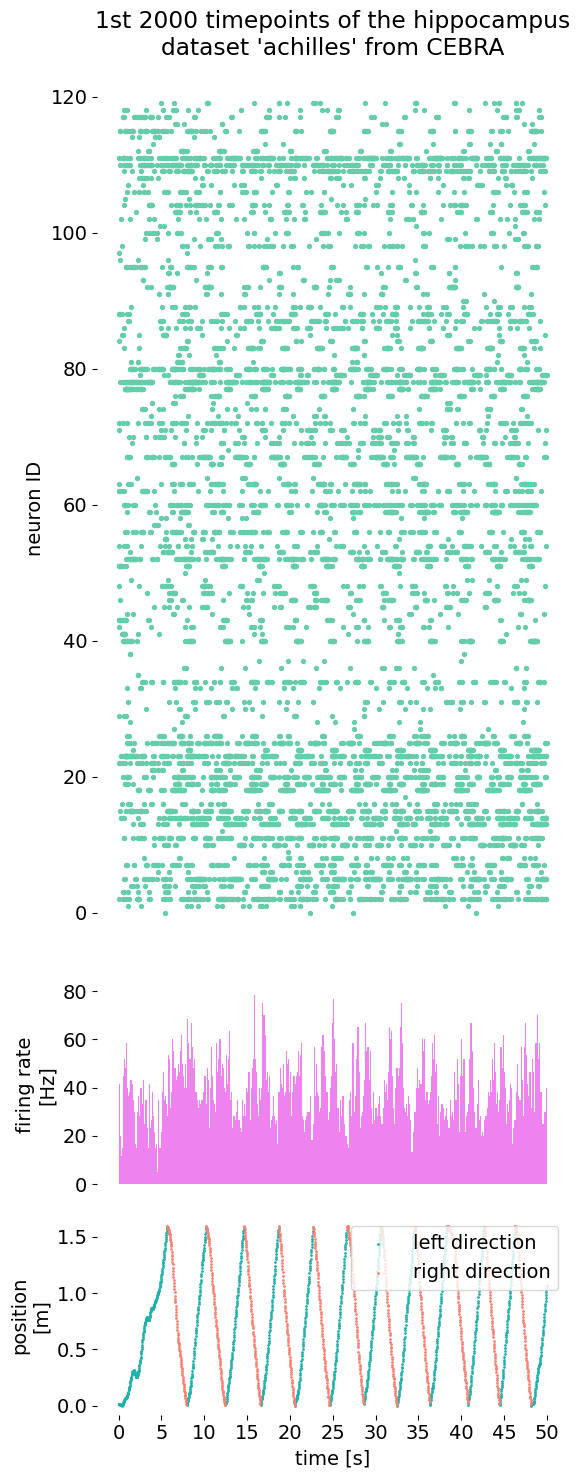

In [30]:
# extract the neurons and timepoints for the scatter plot:
neurons, timepoints = np.where(neuron_spike_times)

# spike raster plot and histogram of spiking rate:
fig = plt.figure(figsize=(6, 8))
gs = gridspec.GridSpec(6, 1)

# create the first subplot (3/4 of the figure)
ax1 = plt.subplot(gs[0:4, :])
ax1.scatter(timepoints, neurons, s=8.0, color='mediumaquamarine', alpha=1.0)
#ax1.imshow(neuron_spike_times, aspect='auto', cmap='viridis', interpolation='none')
plt.title(f"1st {n_timepoints} timepoints of the hippocampus\ndataset 'achilles' from CEBRA")
#ax1.set_xlabel("time [ms]")
ax1.set_xticks([])
ax1.set_ylabel("neuron ID")

# create the second subplot:
ax2 = plt.subplot(gs[4, :])
hist_binwidth = 5.0
t_bins = np.arange(np.amin(timepoints), np.amax(timepoints), hist_binwidth)
n, bins = np.histogram(timepoints, bins=t_bins)
heights = 1000 * n / (hist_binwidth * (N_rec))
ax2.bar(t_bins[:-1], heights, width=hist_binwidth, color='violet')
ax2.set_ylabel("firing rate\n[Hz]")
ax2.set_xticks([])

# create the third subplot:
ax3 = plt.subplot(gs[5, :])
#ax3.plot(np.arange(1000), position_readout, c = 'k')
ax3.scatter(np.arange(n_timepoints)[left_direction == 1],  position_readout[left_direction == 1], 
         c='lightseagreen', label='left direction', s=1)
ax3.scatter(np.arange(n_timepoints)[right_direction == 1], position_readout[right_direction == 1], 
         c='salmon', label='right direction', s=1)
ax3.set_ylabel(f'position\n[m]')
ax3.set_xlabel("time [s]")
ax3.legend(loc="upper right", frameon=True)
ax3.set_xticks(np.arange(0, n_timepoints+1, 200))
ax3.set_xticklabels(np.arange(0, 0.025*n_timepoints+1, 0.025*200).astype("int")) 

plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'AE_behavior_hippocampus_achilles_spike_raster.png'), dpi=300)
plt.show()

We need again to rearrange the data. We need to **feed both neural spike times and position readout** into the VAE:

In [5]:
# prepare dataset by concatenating neuron spikes and position:
neuron_spike_times_flat = neuron_spike_times.T  # shape: (timepoints, neurons)
position_readout_flat = position_readout.reshape(-1, 1)  # shape: (timepoints, 1)
combined_data = np.hstack((neuron_spike_times_flat, position_readout_flat))

# convert the combined data to a tensor:
combined_data_tensor = torch.tensor(combined_data).float()

print(f"Combined data shape: {combined_data.shape}")  # should be (timepoints, neurons + 1)

Combined data shape: (2000, 121)


We again define a custom dataset class for PyTorch's DataLoader. The `CustomDataset` class needs to be modified to include both the neural spike times and the behavior data as inputs for the model:

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        instance = self.data[idx, :]
        return instance

We instantiate the `CustomDataset` class and split the data into training and validation sets:

In [7]:
combined_dataset_tensor = CustomDataset(combined_data_tensor)
train_size = int(0.9 * len(combined_dataset_tensor))
test_size = len(combined_dataset_tensor) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(combined_dataset_tensor, [train_size, test_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=150, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=150, shuffle=True)

## 📝 Implement the Variational Autoencoder (VAE) architecture
Now, we define the VAE model. The VAE model consists of two parts: the encoder and the decoder. The encoder takes the input data and maps it to a latent space. The decoder takes the latent space representation and maps it back to the original input space. In our case, the encoder has two fully connected layers, and outputs the mean and the log-variance of the latent space representation. The decoder mirrors the encoder, and outputs the reconstructed input data.

1. Implement the VAE architecture by completing the code below. Consider the following layers in the encoder and decoder:
    - Encoder:
      - Fully connected layer with 64 units and ReLU activation (in `encode()`), receiving the input data size
      - Fully connected layer with 32 units and ReLU activation(in `encode()`),
      - Fully connected layer with latent_size units for the mean,
      - Fully connected layer with latent_size units for the log-variance.
    - Decoder:
      - should mirror the encoder architecture, with the last layer (in `decode()``) having a sigmoid activation function.
2. Complete the `forward()` method to define the forward pass of the VAE.
3. Implement the `reparameterize()` method to sample from the latent space using the reparameterization trick.

Hint: You can mainly follow our example from the lecture, but make sure to adapt the architecture to the input size of the hippocampus dataset.


In [8]:
# Your code goes here:
# define the VAE architecture:
#class VariationalAutoencoder(nn.Module):
#    def __init__(self, input_size, latent_size):
#        super(VariationalAutoencoder, self).__init__()
        
        # Encoder
        # ...
        
        # Decoder
        # ...

#    def encode(self, x):
        # ...
#        return mu, logvar

#    def reparameterize(self, mu, logvar):
        # ...
#        return mu + eps * std

#    def decode(self, z):
        # ...
#        return torch.sigmoid(self.decoder_fc3(h4))

#    def forward(self, x):
        # ...
#        return recon_x, mu, logvar



# SOL:
# define the VAE architecture:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(VariationalAutoencoder, self).__init__()
        
        # Encoder
        self.encoder_fc1 = nn.Linear(input_size, 64)
        self.encoder_fc2 = nn.Linear(64, 32)
        self.fc_mu = nn.Linear(32, latent_size)
        self.fc_logvar = nn.Linear(32, latent_size)
        
        # Decoder
        self.decoder_fc1 = nn.Linear(latent_size, 32)
        self.decoder_fc2 = nn.Linear(32, 64)
        self.decoder_fc3 = nn.Linear(64, input_size)

    def encode(self, x):
        h1 = torch.relu(self.encoder_fc1(x))
        h2 = torch.relu(self.encoder_fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.decoder_fc1(z))
        h4 = torch.relu(self.decoder_fc2(h3))
        return torch.sigmoid(self.decoder_fc3(h4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


## 📝 Define the loss function
Next, we need to define the loss function. The loss function for the VAE consists of two parts: the reconstruction loss and the KL divergence loss. The reconstruction loss measures how well the model can reconstruct the input data. The KL divergence loss measures how well the latent space representation follows a normal distribution. The total loss is the sum of the reconstruction loss and the KL divergence loss. Here, we use the binary cross-entropy loss for the reconstruction loss since our data is binary.

1. Implement the `loss_function()` method to define the loss function of the VAE. The method should return the total loss, the reconstruction loss, and the KL divergence loss.

In [9]:
# Your code goes here:
#def vae_loss_function(recon_x, x, mu, logvar):
    #...
#    return BCE + KLD

# SOL
# VAE loss function:
def vae_loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

Now we can train our model. We define an according training loop and keep track of both the training and validation losses. Note, that the training can take a while:

In [10]:
# for reproducibility:
torch.manual_seed(0)

# initialize model, optimizer, and device
input_size = combined_data.shape[1]
latent_size = 3
model = VariationalAutoencoder(input_size=input_size, latent_size=latent_size)
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# training loop:
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        
        recon_batch, mu, logvar = model(batch)
        loss = vae_loss_function(recon_batch, batch, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    # validation phase:
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            recon_batch, mu, logvar = model(batch)
            val_loss += vae_loss_function(recon_batch, batch, mu, logvar).item()
    
    avg_val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

Epoch 1/50, Train Loss: 80.599066, Val Loss: 75.638513
Epoch 2/50, Train Loss: 69.662822, Val Loss: 61.252747
Epoch 3/50, Train Loss: 50.994568, Val Loss: 38.540605
Epoch 4/50, Train Loss: 33.893469, Val Loss: 30.168078
Epoch 5/50, Train Loss: 28.263778, Val Loss: 26.309171
Epoch 6/50, Train Loss: 25.447241, Val Loss: 24.930342
Epoch 7/50, Train Loss: 24.141399, Val Loss: 24.280178
Epoch 8/50, Train Loss: 23.372488, Val Loss: 23.260536
Epoch 9/50, Train Loss: 22.781871, Val Loss: 22.754377
Epoch 10/50, Train Loss: 22.375995, Val Loss: 22.617293
Epoch 11/50, Train Loss: 22.130372, Val Loss: 22.450495
Epoch 12/50, Train Loss: 22.017149, Val Loss: 22.151362
Epoch 13/50, Train Loss: 21.656896, Val Loss: 22.109679
Epoch 14/50, Train Loss: 21.546653, Val Loss: 21.574614
Epoch 15/50, Train Loss: 21.474601, Val Loss: 21.476819
Epoch 16/50, Train Loss: 21.270465, Val Loss: 21.365029
Epoch 17/50, Train Loss: 21.239343, Val Loss: 21.427927
Epoch 18/50, Train Loss: 21.089418, Val Loss: 21.253900
E

Let's plot the training and validation losses:

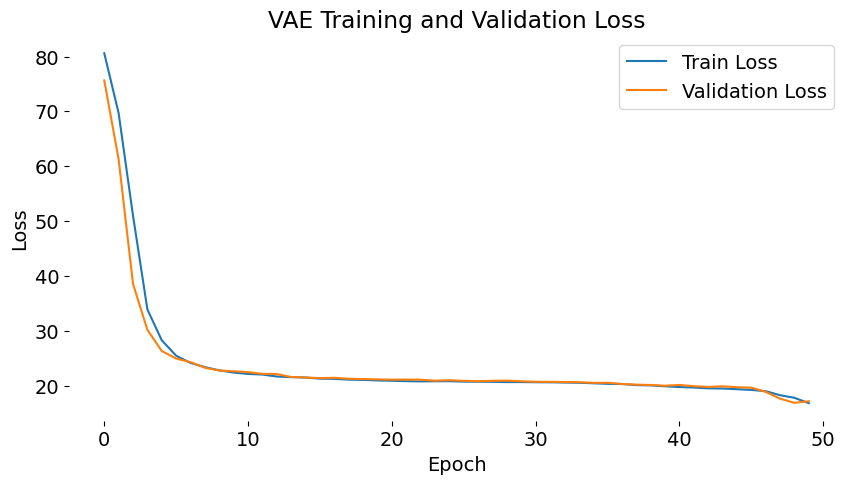

In [11]:
# plot training and validation loss curves:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('VAE Training and Validation Loss')
plt.show()

The VAE seems to have converged. We can now use the trained model to encode the data and visualize the latent space representation. We encode the data and plot the latent space representation:

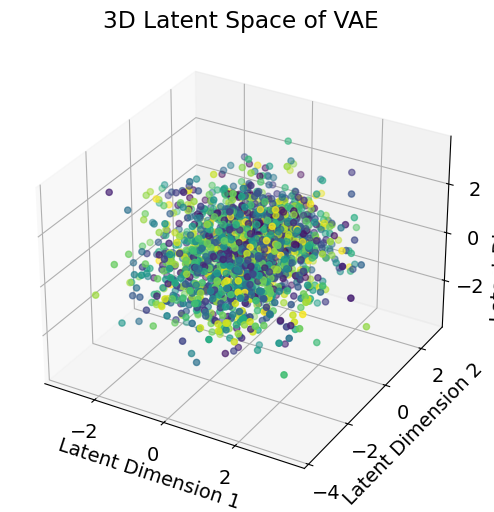

In [12]:
# move the model to evaluation mode and loop through the dataset to get the 
# latent space WITHOUT gradients (=no backpropagation; we don't want to update our model!):
model.eval()
latent_space = []
with torch.no_grad():
    for batch in DataLoader(dataset=combined_dataset_tensor, batch_size=150, shuffle=False):
        batch = batch.to(device)
        mu, logvar = model.encode(batch)
        z = model.reparameterize(mu, logvar)
        latent_space.append(z.cpu().numpy())

# Concatenate latent space results
latent_space = np.concatenate(latent_space, axis=0)

# plot the 3D latent space:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent_space[:, 0], latent_space[:, 1], latent_space[:, 2], c=np.arange(len(latent_space)), cmap='viridis')
ax.set_title("3D Latent Space of VAE")
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.show()

# 📝 Replot the 3D latent space, color-coded by the position of the mouse

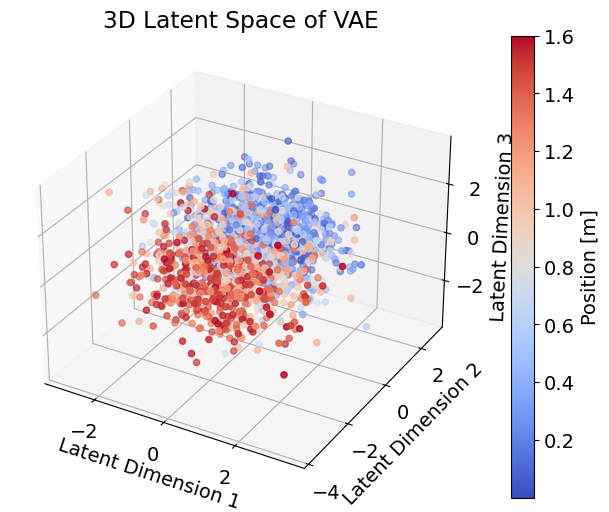

In [13]:
#Your code goes here:

# SOL:
# replot the 3D latent space, color-coded by the position of the mouse:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(latent_space[:, 0], latent_space[:, 1], latent_space[:, 2], c=position_readout, cmap='coolwarm')
cbar = fig.colorbar(sc)
cbar.set_label('Position [m]')
ax.set_title("3D Latent Space of VAE")
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.show()

It seems, that our VAE model is able to structure the data in accordance with the mouse's position (kind of). One could further investigate the latent space representation and try to improve the model by tuning the hyperparameters or the architecture. However, we will stop here and move on to the part, where we train a new VAE with the goal, to predict the mouse's position from the neural data.

# $\beta$-VAE and behavior prediction
Let's try whether we can predict the position of the mouse from the latent space representation by inputting the neural spike times into the decoder. To achieve this, we need to modify the VAE model to have a secondary output that specifically predicts the behavior vector. This model will be trained in a way that it learns to both reconstruct the neural activity and predict the behavior vector from the latent space representation. After training, we can use only the neural data as input to the VAE and obtain the behavior prediction as output.

To proceed, we need to adjust

* data standardization to both the neural data and the behavior data,
* additional data augmentation to the training set in order to increase the model's generalization capabilities, and
* update the CustomDataset class to also include the behavior data as target output for the model and the data augmentation.

In [14]:
# standardize the neural data and behavior data:
scaler_neural = StandardScaler()
scaler_behavior = StandardScaler()

neural_data_scaled = scaler_neural.fit_transform(neuron_spike_times_flat)
behavior_data_scaled = scaler_behavior.fit_transform(position_readout_flat)

# convert data to tensors:
neural_data_tensor = torch.tensor(neural_data_scaled).float()
behavior_data_tensor = torch.tensor(behavior_data_scaled).float()

# define a data augmentation function:
def augment_data(neural_data, behavior_data, noise_level=0.01):
    noise = torch.randn_like(neural_data) * noise_level
    augmented_neural_data = neural_data + noise
    return augmented_neural_data, behavior_data

# custom dataset with augmentation:
class AugmentedDataset(Dataset):
    def __init__(self, neural_data, behavior_data, augment=False):
        self.neural_data = neural_data
        self.behavior_data = behavior_data
        self.augment = augment
        
    def __len__(self):
        return self.neural_data.shape[0]
    
    def __getitem__(self, idx):
        neural_activity = self.neural_data[idx, :]
        behavior = self.behavior_data[idx]
        if self.augment:
            neural_activity, behavior = augment_data(neural_activity, behavior)
        return {"neural_activity": neural_activity, "behavior": behavior}

Instantiate dataset and split into train and test:

In [15]:
combined_dataset_tensor = AugmentedDataset(neural_data_tensor, behavior_data_tensor, augment=True)
train_size = int(0.7 * len(combined_dataset_tensor))
test_size = len(combined_dataset_tensor) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(combined_dataset_tensor, [train_size, test_size])

Let's define the VAE model with a secondary output for the behavior prediction:

In [16]:
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# define the VAE with behavior prediction
class VAEWithBehaviorPrediction(nn.Module):
    def __init__(self, input_size, latent_size, behavior_size):
        super(VAEWithBehaviorPrediction, self).__init__()
        
        # Encoder
        self.encoder_fc1 = nn.Linear(input_size, 64)
        self.encoder_fc2 = nn.Linear(64, 32)
        self.encoder_fc3 = nn.Linear(32, 16)
        self.encoder_fc4 = nn.Linear(16, 8)  # Added layer
        self.fc_mu = nn.Linear(8, latent_size)
        self.fc_logvar = nn.Linear(8, latent_size)
        
        # Decoder for neural data reconstruction
        self.decoder_fc1 = nn.Linear(latent_size, 8)  # Adjusted input size
        self.decoder_fc2 = nn.Linear(8, 16)
        self.decoder_fc3 = nn.Linear(16, 32)
        self.decoder_fc4 = nn.Linear(32, 64)
        self.decoder_fc5 = nn.Linear(64, input_size)  # Added layer
        
        # Behavior prediction from latent space
        dropout_rate = 0.3
        self.behavior_fc1 = nn.Linear(latent_size, 32)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.behavior_fc2 = nn.Linear(32, 16)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.behavior_fc3 = nn.Linear(16, 8)
        self.dropout3 = nn.Dropout(p=dropout_rate)
        self.behavior_fc4 = nn.Linear(8, behavior_size)

    def encode(self, x):
        h1 = torch.relu(self.encoder_fc1(x))
        h2 = torch.relu(self.encoder_fc2(h1))
        h3 = torch.relu(self.encoder_fc3(h2))
        h4 = torch.relu(self.encoder_fc4(h3))  # Added layer
        mu = self.fc_mu(h4)
        logvar = self.fc_logvar(h4)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h4 = torch.relu(self.decoder_fc1(z))
        h5 = torch.relu(self.decoder_fc2(h4))
        h6 = torch.relu(self.decoder_fc3(h5))
        h7 = torch.relu(self.decoder_fc4(h6))  # Added layer
        return torch.sigmoid(self.decoder_fc5(h7))

    def predict_behavior(self, z):
        h7 = torch.relu(self.behavior_fc1(z))
        h8 = torch.relu(self.behavior_fc2(h7))
        h9 = torch.relu(self.behavior_fc3(h8))
        return self.behavior_fc4(h9)  # no activation, as this is a regression task

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        pred_behavior = self.predict_behavior(z)
        return recon_x, pred_behavior, mu, logvar

and adjust the loss function accordingly:

In [17]:
# VAE loss function with behavior prediction:
""" # you will adjust the function later (see exercise below)
def vae_behavior_loss(recon_x, x, pred_behavior, behavior, mu, logvar, beta=0.1):
    # Reconstruction loss for neural activity
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    
    # Kullback-Leibler divergence for VAE, scaled by beta
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Behavior prediction loss (mean squared error)
    behavior_loss = nn.functional.mse_loss(pred_behavior, behavior, reduction='sum')
    
    # Total loss (balance reconstruction, KLD, and behavior prediction)
    return recon_loss +  KLD + behavior_loss
 """
# SOL:
# VAE loss function with behavior prediction:
def vae_behavior_loss(recon_x, x, pred_behavior, behavior, mu, logvar, beta=0.1):
    # Reconstruction loss for neural activity
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    
    # Kullback-Leibler divergence for VAE, scaled by beta
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Behavior prediction loss (mean squared error)
    behavior_loss = nn.functional.mse_loss(pred_behavior, behavior, reduction='sum')
    
    # Total loss (balance reconstruction, KLD, and behavior prediction)
    return recon_loss + beta * KLD + behavior_loss

Initialize the model and optimizer:

In [18]:
# for reproducibility:
torch.manual_seed(2) # 5! 13 32 43!

input_size = neuron_spike_times_flat.shape[1]  # only neural data size
latent_size = 3  # size of latent space
behavior_size = 8  # size of behavior vector (position)
""" 
Actually, we should set behavior_size to 1, as we only have one behavior variable (position). However, the predictor 
performs better for a higher "behavior latent space" size.
"""
model = VAEWithBehaviorPrediction(input_size=input_size, latent_size=latent_size, behavior_size=behavior_size)
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
model = model.to(device)

# adjust the learning rate and optimizer later (see exercise below):
""" learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate) """

# SOL:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0000001)

We need to make some adjustments to the training loop to include the behavior prediction:

In [19]:
# training loop:
kl_beta = 0.5  # 0.5 best value
epochs = 50
train_losses = []
val_losses = []
train_behavior_losses = []
val_behavior_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_behavior_loss = 0
    for batch in train_loader:
        neural_activity = batch['neural_activity'].to(device)
        behavior = batch['behavior'].to(device)
        
        # Forward pass
        recon_neural, pred_behavior, mu, logvar = model(neural_activity)
        
        # Compute losses
        loss = vae_behavior_loss(recon_neural, neural_activity, pred_behavior, behavior, mu, logvar, kl_beta)
        behavior_loss = nn.functional.mse_loss(pred_behavior, behavior, reduction='sum')
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_behavior_loss += behavior_loss.item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_behavior_loss = train_behavior_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_behavior_losses.append(avg_train_behavior_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_behavior_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            neural_activity = batch['neural_activity'].to(device)
            behavior = batch['behavior'].to(device)
            
            # Forward pass
            recon_neural, pred_behavior, mu, logvar = model(neural_activity)
            
            # Compute validation losses
            val_loss += vae_behavior_loss(recon_neural, neural_activity, pred_behavior, behavior, mu, logvar, kl_beta).item()
            val_behavior_loss += nn.functional.mse_loss(pred_behavior, behavior, reduction='sum').item()
    
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_behavior_loss = val_behavior_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    val_behavior_losses.append(avg_val_behavior_loss)
    
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, '
          f'Train Behavior Loss: {avg_train_behavior_loss:.6f}, Val Behavior Loss: {avg_val_behavior_loss:.6f}')


/var/folders/zm/449byhrj6kd2779zy8fs0nvr0000gq/T/ipykernel_280/1229544173.py:26: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  behavior_loss = nn.functional.mse_loss(pred_behavior, behavior, reduction='sum')
/var/folders/zm/449byhrj6kd2779zy8fs0nvr0000gq/T/ipykernel_280/2049382222.py:22: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  behavior_loss = nn.functional.mse_loss(pred_behavior, behavior, reduction='sum')
/var/folders/zm/449byhrj6kd2779zy8fs0nvr0000gq/T/ipykernel_280/2049382222.py:51: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 8])). This will likely lead to incorrect re

Epoch 1/50, Train Loss: 157.126651, Val Loss: 143.675319, Train Behavior Loss: 8.799404, Val Behavior Loss: 8.430313
Epoch 2/50, Train Loss: 152.940617, Val Loss: 137.817646, Train Behavior Loss: 8.613947, Val Behavior Loss: 8.269214
Epoch 3/50, Train Loss: 144.893705, Val Loss: 127.310076, Train Behavior Loss: 8.486665, Val Behavior Loss: 8.154774
Epoch 4/50, Train Loss: 134.190999, Val Loss: 118.439941, Train Behavior Loss: 8.375030, Val Behavior Loss: 8.049331
Epoch 5/50, Train Loss: 128.926884, Val Loss: 116.726917, Train Behavior Loss: 8.275363, Val Behavior Loss: 7.962805
Epoch 6/50, Train Loss: 128.003762, Val Loss: 116.281755, Train Behavior Loss: 8.207532, Val Behavior Loss: 7.913991
Epoch 7/50, Train Loss: 127.786593, Val Loss: 116.140138, Train Behavior Loss: 8.168868, Val Behavior Loss: 7.881910
Epoch 8/50, Train Loss: 127.674214, Val Loss: 116.091634, Train Behavior Loss: 8.139258, Val Behavior Loss: 7.866504
Epoch 9/50, Train Loss: 127.621256, Val Loss: 116.055265, Train 

Let's take a look at both the loss curves of the neural activity reconstruction and the behavior prediction:

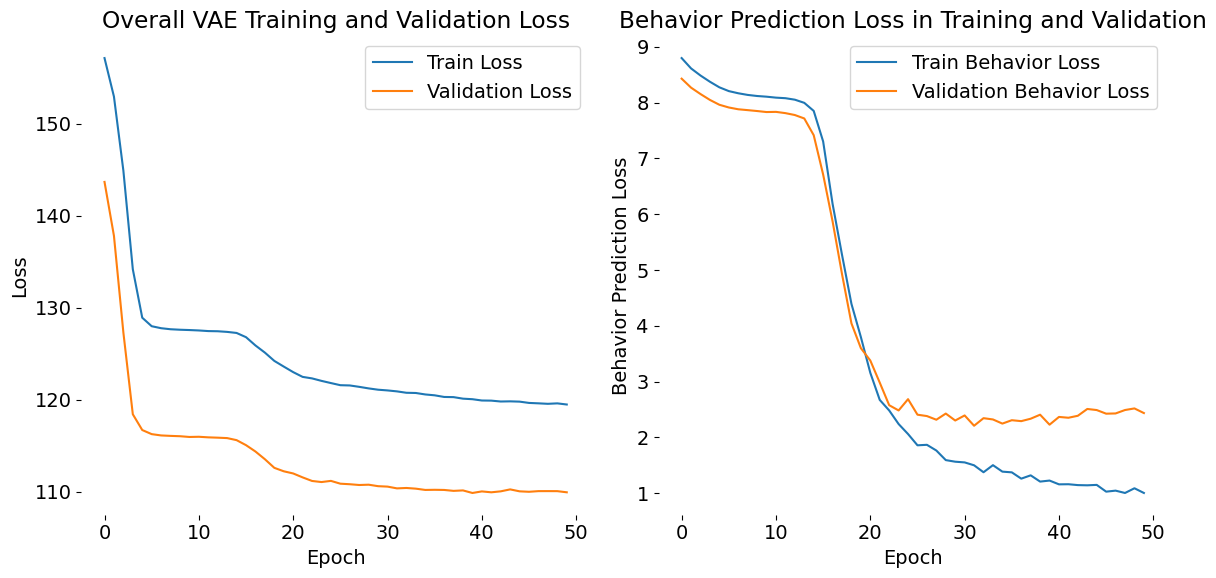

In [20]:
# plot training and validation loss curves:
plt.figure(figsize=(12, 6))

# plot overall training and validation loss:
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Overall VAE Training and Validation Loss')

# plot behavior prediction loss specifically
plt.subplot(1, 2, 2)
plt.plot(train_behavior_losses, label='Train Behavior Loss')
plt.plot(val_behavior_losses, label='Validation Behavior Loss')
plt.xlabel('Epoch')
plt.ylabel('Behavior Prediction Loss')
plt.legend()
plt.title('Behavior Prediction Loss in Training and Validation')

plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'VAE_behavior_prediction_loss_detailed.png'), dpi=300)
plt.show()

It seems like our updated VAE does not perform well on the behavior prediction task. This could be due to the fact that the latent space representation does not contain enough information to predict the behavior. However, let's take a look at the actual prediction performance:

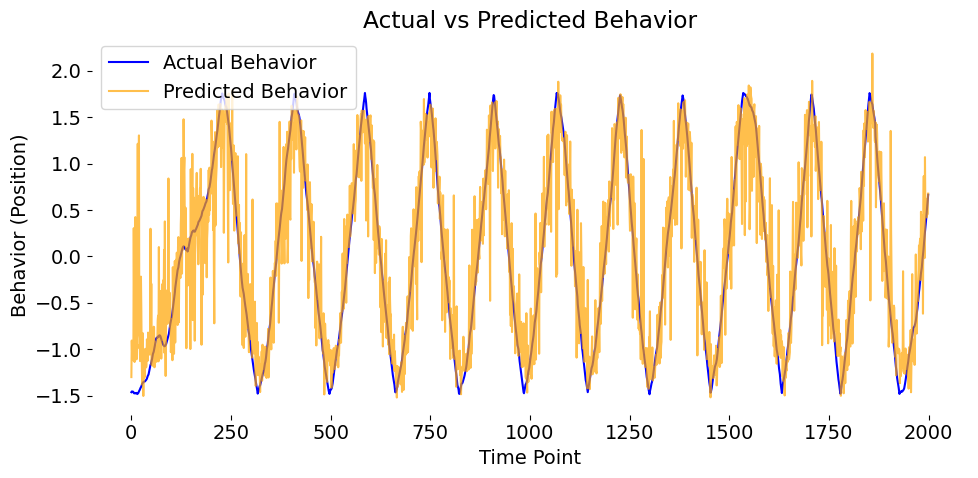

In [26]:
# prediction of behavior from neural activity:
model.eval()
neural_data_only_loader = DataLoader(dataset=combined_dataset_tensor, batch_size=128, shuffle=False)
predicted_behaviors = []
actual_behaviors = []

with torch.no_grad():
    for batch in neural_data_only_loader:
        neural_activity = batch['neural_activity'].to(device)
        behavior = batch['behavior'].to(device)
        
        _, pred_behavior, _, _ = model(neural_activity)
        predicted_behaviors.append(pred_behavior.cpu().numpy())
        actual_behaviors.append(behavior.cpu().numpy())

# Concatenate and plot the behavior prediction
predicted_behaviors = np.concatenate(predicted_behaviors, axis=0)
actual_behaviors = np.concatenate(actual_behaviors, axis=0)

if behavior_size >1:
    predicted_behaviors_avrg = np.mean(predicted_behaviors, axis=1)
    """
    due to the higher dimension of the behavior latent space, we need to average the 
    predictions to get a 1D behavior prediction array for plotting.
    """
else:
    predicted_behaviors_avrg = predicted_behaviors

plt.figure(figsize=(10, 5))
plt.plot(actual_behaviors, label='Actual Behavior', color='blue')
plt.plot(predicted_behaviors_avrg, label='Predicted Behavior', color='orange', alpha=0.7)
plt.xlabel('Time Point')
plt.ylabel('Behavior (Position)')
plt.legend()
plt.title('Actual vs Predicted Behavior')
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'VAE_behavior_prediction.png'), dpi=300)
plt.show()

Surprisingly, the model seems to perform quite well on the behavior prediction task. This could be due to the fact that the behavior is highly correlated with the neural activity. However, the model might not generalize well to new data. 

As a last step, let's visualize the latent space representation and the behavior prediction:

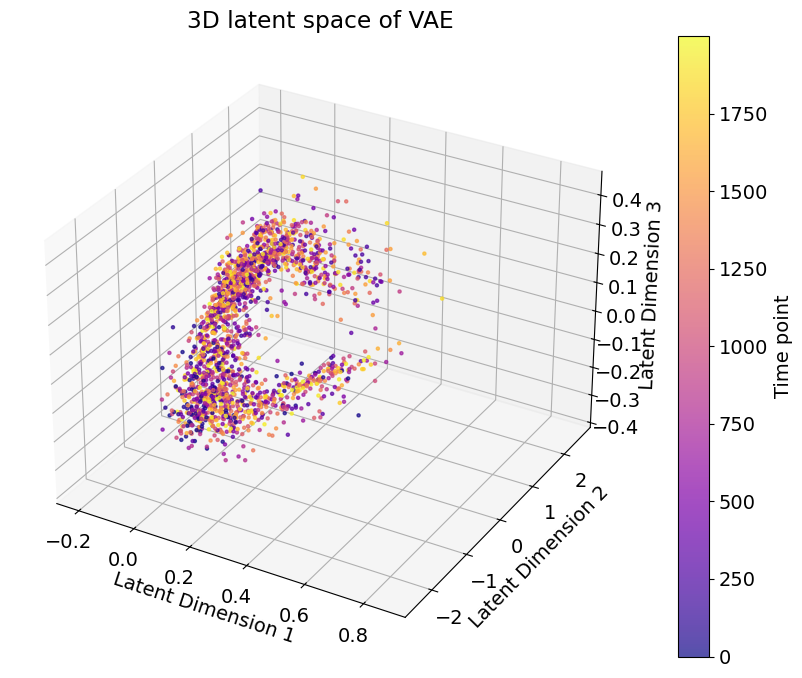

In [22]:
# extract latent space representation from the full dataset:
model.eval()
latent_mu_values = []

with torch.no_grad():
    for batch in neural_data_only_loader:
        neural_activity = batch['neural_activity'].to(device)
        mu, _ = model.encode(neural_activity)
        latent_mu_values.append(mu.cpu().numpy())

# concatenate the latent space representations:
latent_mu_values = np.concatenate(latent_mu_values, axis=0)

# plotting the 3D latent space:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(latent_mu_values[:, 0], latent_mu_values[:, 1], latent_mu_values[:, 2], 
                c=np.arange(len(latent_mu_values)), cmap='plasma', s=5, alpha=0.7)
plt.colorbar(sc, label='Time point')
ax.set_title("3D latent space of VAE")
ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
ax.set_zlabel("Latent Dimension 3")
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'VAE_3D_latent_space.png'), dpi=300)
plt.show()

# 📝 Replot latent space with real behavior color-coding
1. Replot the latent space with real behavior color-coding (left/right direction)
2. Add 3x 2D scatter plots for the latent space representation, color-coded by the left/right direction of the mouse.

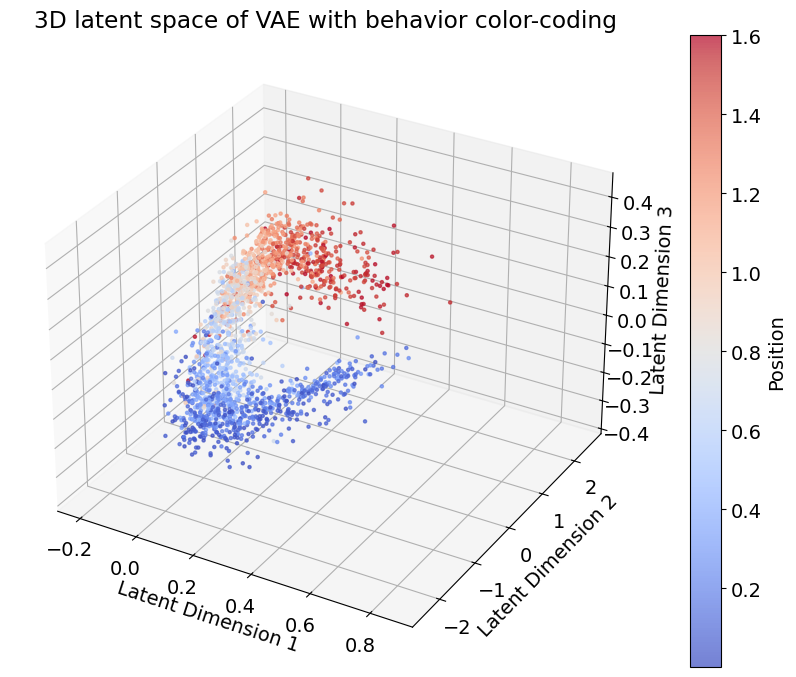

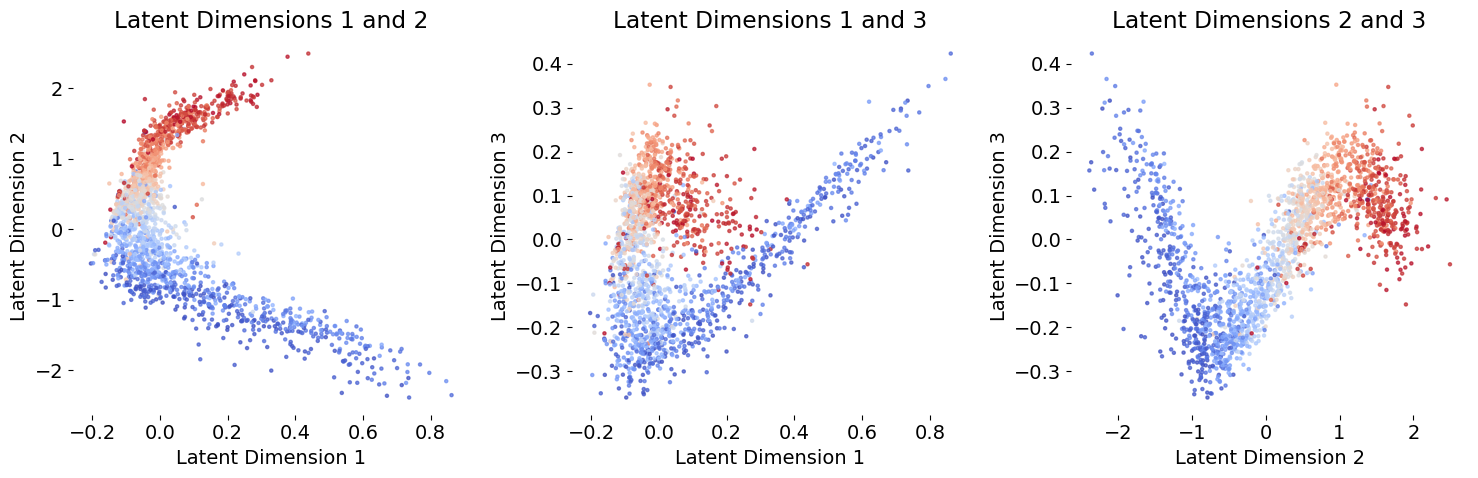

In [23]:
# Your code goes here:

# SOL:
# replot latent space with real behavior color-coding (left/right direction):
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(latent_mu_values[:, 0], latent_mu_values[:, 1], latent_mu_values[:, 2],
                c=position_readout, cmap='coolwarm', s=5, alpha=0.7)
plt.colorbar(sc, label='Position')
ax.set_title("3D latent space of VAE with behavior color-coding")
ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
ax.set_zlabel("Latent Dimension 3")
# rotate the plot for better visualization:
#ax.view_init(elev=30, azim=30)
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'VAE_3D_latent_space_behavior_color.png'), dpi=300)
plt.show()

# plot the 2D projections of the latent space in a 1x3 subplot:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(latent_mu_values[:, 0], latent_mu_values[:, 1], c=position_readout, cmap='coolwarm', s=5, alpha=0.7)
axs[0].set_title("Latent Dimensions 1 and 2")
axs[0].set_xlabel("Latent Dimension 1")
axs[0].set_ylabel("Latent Dimension 2")

axs[1].scatter(latent_mu_values[:, 0], latent_mu_values[:, 2], c=position_readout, cmap='coolwarm', s=5, alpha=0.7)
axs[1].set_title("Latent Dimensions 1 and 3")
axs[1].set_xlabel("Latent Dimension 1")
axs[1].set_ylabel("Latent Dimension 3")

axs[2].scatter(latent_mu_values[:, 1], latent_mu_values[:, 2], c=position_readout, cmap='coolwarm', s=5, alpha=0.7)
axs[2].set_title("Latent Dimensions 2 and 3")
axs[2].set_xlabel("Latent Dimension 2")
axs[2].set_ylabel("Latent Dimension 3")

plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'VAE_2D_latent_space_behavior_color.png'), dpi=300)
plt.show()

In [24]:



""" 
The visualization of the 3D VAE latent space suggests some unusual structure. The data points 
are almost aligned along a thin line, with very little spread across the latent dimensions. 
This pattern could indicate several possible issues or limitations in how the VAE is representing the data:

1. Insufficient Capacity of the Latent Space: The VAE's latent space may be too limited (or regularized too heavily) to capture the complexity of the input data, resulting in a "collapsed" latent space where most points lie along a single dimension or line. This could be due to a very small latent space (e.g., only 3 dimensions) for highly complex data.
2. Too Strong Regularization from the KL Divergence Term: The Kullback-Leibler divergence (KL term) in the VAE loss might be overpowering the reconstruction loss, pushing the latent variables closer to a single point or a narrow region in the latent space. This happens if the balance between reconstruction loss and KL divergence isn’t optimized correctly. You could try reducing the weight of the KL term relative to the reconstruction term to allow the latent variables more freedom.
3. Inadequate Encoder Network Complexity: The encoder network might be too simple to map the input data to a well-distributed latent space. Increasing the complexity of the encoder by adding more layers or increasing the layer sizes could improve the diversity in the latent space.
4. Data Characteristics: It’s also possible that the data itself doesn’t have sufficient variation for a 3D latent space to learn distinct patterns. This is less likely but can happen if the data doesn’t contain much underlying diversity.
5. High-Dimensional Data Compression: The data might be too high-dimensional for the VAE to compress effectively into just 3 latent dimensions, causing a form of "information bottleneck." Increasing the latent dimensionality (e.g., from 3 to 5 or 10) could help in better representing the data.

Suggested Next Steps:
1. Experiment with Latent Space Dimensionality: Try increasing the latent dimensionality, perhaps to 5 or even 10, and observe if the latent space gains more structure.
2. Adjust KL Loss Weight: You could try reducing the influence of the KL divergence term in the loss function by scaling it down (e.g., multiplying it by a factor less than 1). This might allow the model more freedom to distribute points in the latent space.
3. Increase Encoder Complexity: Add more layers or increase the width of the layers in the encoder to allow for more complex mappings from the input space to the latent space.
4. Visualize Pairwise 2D Projections: To get more insight, you could plot pairwise 2D projections of the 3D latent space (e.g., Latent Dimension 1 vs. 2, Latent Dimension 1 vs. 3, etc.). This could help in understanding if the alignment is truly along one dimension or if there is hidden structure in other dimensions.


To adjust the weight of the KL divergence term in the VAE loss function, you can introduce a scaling factor
(commonly called the beta parameter) for the KL term. This approach is often referred to as a β-VAE (beta-VAE),
where a hyperparameter β is used to control the strength of the KL divergence term relative to the reconstruction 
loss. By choosing a value for β less than 1, you effectively reduce the influence of the KL divergence, allowing 
the model more flexibility in how it organizes the latent space.
"""

' \nThe visualization of the 3D VAE latent space suggests some unusual structure. The data points \nare almost aligned along a thin line, with very little spread across the latent dimensions. \nThis pattern could indicate several possible issues or limitations in how the VAE is representing the data:\n\n1. Insufficient Capacity of the Latent Space: The VAE\'s latent space may be too limited (or regularized too heavily) to capture the complexity of the input data, resulting in a "collapsed" latent space where most points lie along a single dimension or line. This could be due to a very small latent space (e.g., only 3 dimensions) for highly complex data.\n2. Too Strong Regularization from the KL Divergence Term: The Kullback-Leibler divergence (KL term) in the VAE loss might be overpowering the reconstruction loss, pushing the latent variables closer to a single point or a narrow region in the latent space. This happens if the balance between reconstruction loss and KL divergence isn’t 

# 📝 Tune the model
The visualization of the 3D VAE latent space suggests some unusual structure. The data points are almost aligned along a thin line, with very little spread across the latent dimensions. This pattern could indicate several possible issues or limitations in how the VAE is currently representing the data:

* **Insufficient capacity of the latent space**: The VAE's latent space may be too limited (or regularized too heavily) to capture the complexity of the input data, resulting in a "collapsed" latent space where most points lie along a single dimension or line. This could be due to a very small latent space (e.g., only 3 dimensions) for highly complex data.
* **Too strong regularization from the KL divergence term**: The Kullback-Leibler divergence (KL term) in the VAE loss might be overpowering the reconstruction loss, pushing the latent variables closer to a single point or a narrow region in the latent space. This happens if the balance between reconstruction loss and KL divergence isn't optimized correctly. 
* **Inadequate encoder network complexity**: The encoder network might be too simple to map the input data to a well-distributed latent space. Increasing the complexity of the encoder by adding more layers or increasing the layer sizes could improve the diversity in the latent space.
* Data characteristics: It's also possible that the data itself doesn’t have sufficient variation for a 3D latent space to learn distinct patterns. This is less likely but can happen if the data doesn't contain much underlying diversity.
* **High-dimensional data compression**: The data might be too high-dimensional for the VAE to compress effectively into just 3 latent dimensions, causing a form of "information bottleneck". Increasing the latent dimensionality (e.g., from 3 to 5 or 10) could help in better representing the data.

Let's try to improve the model implementing some improvements. We will address some of the issues mentioned above:

Process the suggestions below step-by-step, .i.e., do not implement all suggestions at once and retrain the model after each step. You can also try to implement your own ideas to improve the model.

1. Change the loss function to a **$beta$ regulated loss function**.
2. Add **weight decay** (`weight_decay=0.001`) to the optimizer to reduce overfitting. Fine-tune the model by iteratively adjusting the **learning rate** and the weight decay. Try smaller learning rates and weight decays. You will most likel not get a perfect convergence of the model, but try to get a better performance on the behavior prediction task and especially in the latent space structure.
3. When you're satisfied with the model's performance, change the **random seed** and retrain the model to see if the model's performance is consistent across different random seeds. What do you notice?

SOL 3: The final structure of the VAE latent space is highly depending on the random seed. This is due to the randomness in the parameters included in the model. This is a common issue in VAE in particular and in deep learning models in general. Thus, it is important to (re)set a fixed random seed at each training to ensure reproducibility of your results. Additionally, change that fixed random seed to see how the model's performance changes across different random seeds; you may even get a better performance by processing this step.